# Neural Network Implementation From Scratch
Modern machine learning libraries such as PyTorch and Keras are invaluable to data scientists across the globe. These libraries offer high-level abstractions of the underlying mathematical processes to direct focus onto model design and experimentation. In other words, libraries make it easy to focus on the "what" and lose sight of the "how."

Too often, students dive head first into machine learning libraries without a solid grasp on the fundamentals—I was guilty of this myself. After taking higher level courses in linear algebra, I aimed to solidify my understanding of the math behind neural networks by implementing one from scratch. In doing so, I've strengthened my understanding of neural networks and gained valuable intuition that I will be able to carry over into my practical machine learning projects.

This implementation uses MNIST training data for simplicity.

In [185]:
# Import libraries
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
import pickle
from tqdm import tqdm

In [186]:
# Load in dataset
data_dir = "data/"
train_df = pd.read_csv(f"{data_dir}/mnist_train.csv")
test_df = pd.read_csv(f"{data_dir}/mnist_test.csv")

train_df.head()

,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [187]:
# Create numpy array representing all training/test images
train_data = train_df.to_numpy()
np.random.shuffle(train_data)
print(train_data)

test_data = test_df.to_numpy()
np.random.shuffle(test_data)
print(test_data)

[[8 0 0 ... 0 0 0]
 [7 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 ...
 [9 0 0 ... 0 0 0]
 [9 0 0 ... 0 0 0]
 [6 0 0 ... 0 0 0]]
[[7 0 0 ... 0 0 0]
 [2 0 0 ... 0 0 0]
 [3 0 0 ... 0 0 0]
 ...
 [6 0 0 ... 0 0 0]
 [9 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [188]:
# Separate image data from labels

# Designate 20% of training data as validation data
X = train_data[:, 1:]
Y = train_data[:, 0]
X_train, X_valid, Y_train, Y_valid = train_test_split(X, Y, test_size=0.2, random_state=42)
print(X_train)

X_test = test_data[:, 1:]
Y_test = test_data[:, 0]
print(X_test)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [189]:
# Normalize data
X_train = X_train / 255
print(X_train)

X_valid = X_valid / 255
print(X_valid)

X_test = X_test / 255
print(X_test)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [190]:
n, m = X_train.shape
output_size = 10
hidden_size = m // 3
print(m)
print(hidden_size)
print(output_size)
X_train.shape

784
261
10


(48000, 784)

In [191]:
# Define activation function for hidden layer
def sigmoid(Z):
    return 1 / (1 + np.exp(-Z))

def sigmoid_derivative(Z):
    ds = sigmoid(Z)
    return ds * (1 - ds)

# Define probability function for output layer
def softmax(Z):
    exps = np.exp(Z - np.max(Z, axis=1, keepdims=True))
    prob = exps / np.sum(exps, axis=1, keepdims=True)
    return prob

I implemented Xavier initialization to combat exploding gradients, an issue I faced early in the process of building this neural network.

In [192]:
#Initialize weights and biases
def init_params():
    W1 = np.random.randn(m, hidden_size) * np.sqrt(2 / m)
    b1 = np.zeros(hidden_size)
    W2 = np.random.randn(hidden_size, output_size) * np.sqrt(2 / hidden_size)
    b2 = np.zeros(output_size)
    return W1, b1, W2, b2

In [193]:
# Define forward propagation
def forward_prop(W1, b1, W2, b2, X):
    Z1 = np.dot(X, W1) + b1
    A1 = sigmoid(Z1)
    Z2 = np.dot(A1, W2) + b2
    A2 = softmax(Z2)
    return Z1, A1, Z2, A2

In [194]:
def one_hot(Y):
    one_hot_Y = np.zeros((Y.size, output_size))
    one_hot_Y[np.arange(Y.size), Y] = 1
    return one_hot_Y

Originally, I neglected to include one hot encoding in my backward propagation implementation. The reason for its use is largely to prevent the model from assuming any order in the labels.

Let's say the correct label for an image is 1. Just because 2 comes right after 1 doesn't mean it is any better of a prediction than 9. Wrong is wrong!

In [195]:
# Define backward propagation
def backward_prop(Z1, A1, Z2, A2, W2, X, Y):
    batch_size = len(X)
    one_hot_Y = one_hot(Y)
   
    dZ2 = A2 - one_hot_Y
    dW2 = np.dot(A1.T, dZ2) / batch_size
    db2 = np.sum(dZ2, axis=0) / batch_size
    dZ1 = np.dot(dZ2, W2.T) * sigmoid_derivative(Z1)
    dW1 = np.dot(X.T, dZ1) / batch_size
    db1 = np.sum(dZ1, axis=0) / batch_size 

    return dW1, db1, dW2, db2

We want to use cross entropy loss as our loss function here since we're working on a classification problem.

In [196]:
def compute_accuracy(X_pred, Y):
    preds = np.argmax(X_pred, axis=1)
    accuracy = np.mean(preds == Y)
    return accuracy

def compute_cross_entropy_loss(X_pred, Y):
    M = len(Y)
    log_likelihood = -np.log(X_pred[range(M), Y])
    loss = np.sum(log_likelihood) / M
    return loss

In [197]:
def make_predictions(W1, b1, W2, b2, X_test, Y_test):
    _, _, _, A2 = forward_prop(W1, b1, W2, b2, X_test)
    test_accuracy = compute_accuracy(A2, Y_test)
    return test_accuracy

In [198]:
def train(X, Y, learning_rate=0.01, batch_size=32, epochs=5):
    W1, b1, W2, b2 = init_params()
    train_loss_data = []
    valid_loss_data = []
    for epoch in range(epochs):
        for batch_start in tqdm(range(0, len(X), batch_size)):
            batch_end = min(batch_start + batch_size, len(X))
            X_batch = X[batch_start:batch_end]
            Y_batch = Y[batch_start:batch_end]
            
            Z1, A1, Z2, A2 = forward_prop(W1, b1, W2, b2, X_batch)
            train_loss = compute_cross_entropy_loss(A2, Y_batch)
            accuracy = compute_accuracy(A2, Y_batch)
            dW1, db1, dW2, db2 = backward_prop(Z1, A1, Z2, A2, W2, X_batch, Y_batch)

            # Update weights and biases
            W1 -= learning_rate * dW1
            b1 -= learning_rate * db1
            W2 -= learning_rate * dW2
            b2 -= learning_rate * db2
        
            valid_Z1, valid_A1, valid_Z2, valid_A2 = forward_prop(W1, b1, W2, b2, X_valid)
            valid_loss = compute_cross_entropy_loss(valid_A2, Y_valid)

            train_loss_data.append(train_loss)
            valid_loss_data.append(valid_loss)

            plt.plot(train_loss_data, color="blue")
            plt.plot(valid_loss_data, color="orange")

            if (batch_start // batch_size) % 100 == 0:
                    print(f"Batch {batch_start // batch_size}: Loss = {train_loss:.4f}, Accuracy = {accuracy:.4f}")

        plt.show()
                
    return W1, b1, W2, b2

  0%|          | 0/750 [00:00<?, ?it/s]

Batch 0: Loss = 2.4709, Accuracy = 0.1406


 14%|█▍        | 105/750 [00:04<00:26, 23.90it/s]

Batch 100: Loss = 1.2182, Accuracy = 0.7656


 27%|██▋       | 204/750 [00:08<00:23, 23.72it/s]

Batch 200: Loss = 0.8376, Accuracy = 0.7812


 40%|████      | 303/750 [00:12<00:22, 20.18it/s]

Batch 300: Loss = 0.7181, Accuracy = 0.8750


 54%|█████▍    | 405/750 [00:17<00:15, 22.82it/s]

Batch 400: Loss = 0.4851, Accuracy = 0.8750


 67%|██████▋   | 504/750 [00:21<00:10, 23.13it/s]

Batch 500: Loss = 0.3454, Accuracy = 0.9062


 80%|████████  | 603/750 [00:25<00:06, 22.86it/s]

Batch 600: Loss = 0.4947, Accuracy = 0.8594


 94%|█████████▍| 705/750 [00:30<00:01, 22.87it/s]

Batch 700: Loss = 0.5005, Accuracy = 0.8750


100%|██████████| 750/750 [00:32<00:00, 23.13it/s]


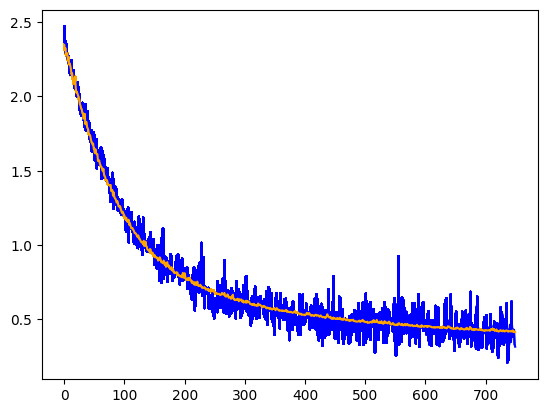

  0%|          | 3/750 [00:00<00:34, 21.66it/s]

Batch 0: Loss = 0.3751, Accuracy = 0.9219


 14%|█▍        | 105/750 [00:04<00:27, 23.10it/s]

Batch 100: Loss = 0.3325, Accuracy = 0.8906


 27%|██▋       | 204/750 [00:08<00:23, 23.02it/s]

Batch 200: Loss = 0.3751, Accuracy = 0.8750


 40%|████      | 303/750 [00:13<00:22, 19.52it/s]

Batch 300: Loss = 0.5498, Accuracy = 0.9219


 54%|█████▍    | 405/750 [00:17<00:14, 23.04it/s]

Batch 400: Loss = 0.2957, Accuracy = 0.8906


 67%|██████▋   | 504/750 [00:22<00:10, 22.87it/s]

Batch 500: Loss = 0.2323, Accuracy = 0.9062


 80%|████████  | 603/750 [00:26<00:06, 23.00it/s]

Batch 600: Loss = 0.4161, Accuracy = 0.8594


 94%|█████████▍| 705/750 [00:30<00:01, 23.01it/s]

Batch 700: Loss = 0.4234, Accuracy = 0.9062


100%|██████████| 750/750 [00:32<00:00, 22.89it/s]


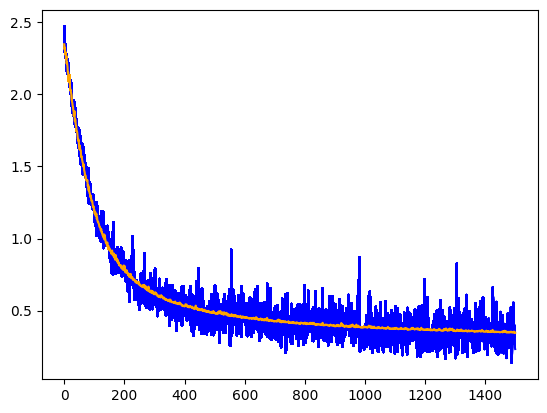

  0%|          | 3/750 [00:00<00:34, 21.79it/s]

Batch 0: Loss = 0.3301, Accuracy = 0.9375


 14%|█▍        | 105/750 [00:04<00:27, 23.24it/s]

Batch 100: Loss = 0.2410, Accuracy = 0.9219


 27%|██▋       | 204/750 [00:08<00:23, 23.15it/s]

Batch 200: Loss = 0.3107, Accuracy = 0.9219


 40%|████      | 303/750 [00:13<00:19, 22.93it/s]

Batch 300: Loss = 0.5296, Accuracy = 0.9219


 54%|█████▍    | 405/750 [00:17<00:15, 22.27it/s]

Batch 400: Loss = 0.2450, Accuracy = 0.9375


 67%|██████▋   | 504/750 [00:22<00:10, 22.99it/s]

Batch 500: Loss = 0.2013, Accuracy = 0.9219


 80%|████████  | 603/750 [00:26<00:06, 23.14it/s]

Batch 600: Loss = 0.3934, Accuracy = 0.8750


 94%|█████████▍| 705/750 [00:30<00:01, 23.15it/s]

Batch 700: Loss = 0.3836, Accuracy = 0.9062


100%|██████████| 750/750 [00:32<00:00, 22.82it/s]


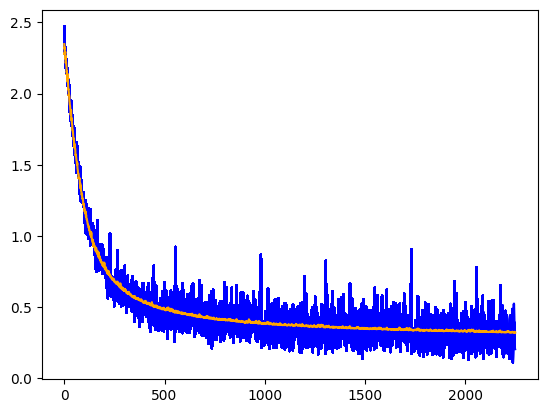

  1%|          | 5/750 [00:00<00:34, 21.37it/s]

Batch 0: Loss = 0.3182, Accuracy = 0.9219


 14%|█▍        | 104/750 [00:04<00:28, 22.39it/s]

Batch 100: Loss = 0.1998, Accuracy = 0.9219


 27%|██▋       | 203/750 [00:08<00:22, 24.30it/s]

Batch 200: Loss = 0.2816, Accuracy = 0.9219


 41%|████      | 305/750 [00:12<00:18, 23.94it/s]

Batch 300: Loss = 0.5160, Accuracy = 0.9219


 54%|█████▍    | 404/750 [00:16<00:14, 23.92it/s]

Batch 400: Loss = 0.2165, Accuracy = 0.9375


 67%|██████▋   | 503/750 [00:21<00:10, 23.85it/s]

Batch 500: Loss = 0.1847, Accuracy = 0.9219


 81%|████████  | 605/750 [00:25<00:06, 24.05it/s]

Batch 600: Loss = 0.3769, Accuracy = 0.8750


 94%|█████████▍| 704/750 [00:29<00:01, 23.26it/s]

Batch 700: Loss = 0.3542, Accuracy = 0.9219


100%|██████████| 750/750 [00:31<00:00, 23.82it/s]


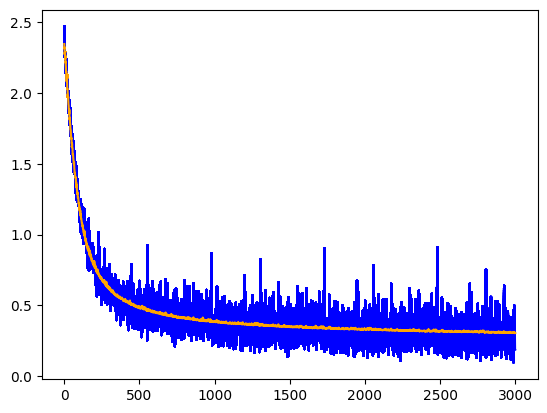

  0%|          | 3/750 [00:00<00:33, 22.40it/s]

Batch 0: Loss = 0.3111, Accuracy = 0.9219


 14%|█▍        | 104/750 [00:04<00:28, 22.36it/s]

Batch 100: Loss = 0.1750, Accuracy = 0.9375


 27%|██▋       | 203/750 [00:09<00:23, 23.44it/s]

Batch 200: Loss = 0.2625, Accuracy = 0.9375


 41%|████      | 305/750 [00:13<00:18, 23.54it/s]

Batch 300: Loss = 0.5011, Accuracy = 0.9219


 54%|█████▍    | 404/750 [00:17<00:14, 24.30it/s]

Batch 400: Loss = 0.1966, Accuracy = 0.9219


 67%|██████▋   | 503/750 [00:21<00:10, 23.89it/s]

Batch 500: Loss = 0.1725, Accuracy = 0.9219


 81%|████████  | 605/750 [00:25<00:06, 23.69it/s]

Batch 600: Loss = 0.3616, Accuracy = 0.8750


 94%|█████████▍| 704/750 [00:30<00:01, 24.33it/s]

Batch 700: Loss = 0.3294, Accuracy = 0.9219


100%|██████████| 750/750 [00:31<00:00, 23.47it/s]


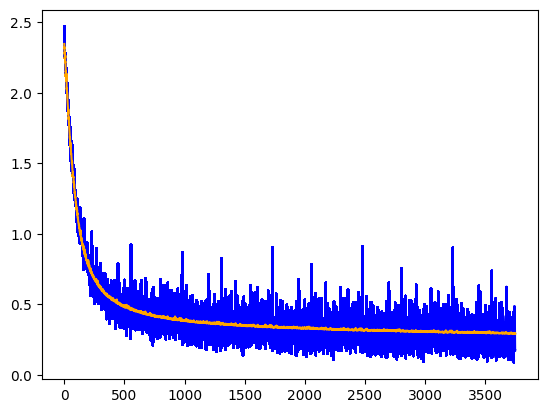

  0%|          | 3/750 [00:00<00:32, 22.96it/s]

Batch 0: Loss = 0.3042, Accuracy = 0.9219


 14%|█▍        | 105/750 [00:04<00:26, 24.66it/s]

Batch 100: Loss = 0.1573, Accuracy = 0.9531


 27%|██▋       | 204/750 [00:08<00:22, 24.38it/s]

Batch 200: Loss = 0.2470, Accuracy = 0.9375


 40%|████      | 303/750 [00:12<00:19, 23.17it/s]

Batch 300: Loss = 0.4844, Accuracy = 0.9219


 54%|█████▍    | 405/750 [00:16<00:14, 24.03it/s]

Batch 400: Loss = 0.1811, Accuracy = 0.9375


 67%|██████▋   | 504/750 [00:20<00:10, 24.24it/s]

Batch 500: Loss = 0.1619, Accuracy = 0.9219


 80%|████████  | 603/750 [00:25<00:06, 24.07it/s]

Batch 600: Loss = 0.3462, Accuracy = 0.8750


 94%|█████████▍| 705/750 [00:29<00:01, 24.10it/s]

Batch 700: Loss = 0.3073, Accuracy = 0.9219


100%|██████████| 750/750 [00:31<00:00, 24.00it/s]


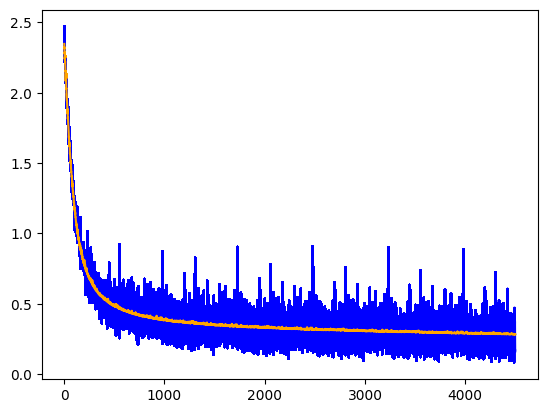

  0%|          | 3/750 [00:00<00:31, 23.45it/s]

Batch 0: Loss = 0.2965, Accuracy = 0.9219


 14%|█▍        | 105/750 [00:04<00:26, 24.80it/s]

Batch 100: Loss = 0.1429, Accuracy = 0.9531


 27%|██▋       | 204/750 [00:08<00:22, 24.72it/s]

Batch 200: Loss = 0.2327, Accuracy = 0.9375


 40%|████      | 303/750 [00:12<00:18, 24.57it/s]

Batch 300: Loss = 0.4659, Accuracy = 0.9219


 54%|█████▍    | 405/750 [00:16<00:14, 24.63it/s]

Batch 400: Loss = 0.1681, Accuracy = 0.9375


 67%|██████▋   | 504/750 [00:20<00:09, 24.87it/s]

Batch 500: Loss = 0.1522, Accuracy = 0.9375


 80%|████████  | 603/750 [00:24<00:05, 24.58it/s]

Batch 600: Loss = 0.3303, Accuracy = 0.8906


 94%|█████████▍| 705/750 [00:28<00:01, 24.55it/s]

Batch 700: Loss = 0.2872, Accuracy = 0.9531


100%|██████████| 750/750 [00:30<00:00, 24.54it/s]


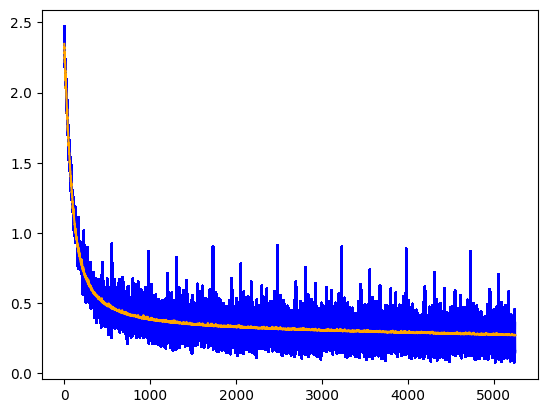

  0%|          | 3/750 [00:00<00:33, 22.60it/s]

Batch 0: Loss = 0.2876, Accuracy = 0.9219


 14%|█▍        | 105/750 [00:04<00:26, 24.44it/s]

Batch 100: Loss = 0.1304, Accuracy = 0.9531


 27%|██▋       | 204/750 [00:08<00:22, 24.38it/s]

Batch 200: Loss = 0.2189, Accuracy = 0.9375


 40%|████      | 303/750 [00:12<00:18, 24.48it/s]

Batch 300: Loss = 0.4462, Accuracy = 0.9219


 54%|█████▍    | 405/750 [00:16<00:14, 24.54it/s]

Batch 400: Loss = 0.1569, Accuracy = 0.9375


 67%|██████▋   | 504/750 [00:20<00:09, 25.00it/s]

Batch 500: Loss = 0.1431, Accuracy = 0.9375


 81%|████████  | 606/750 [00:24<00:05, 24.80it/s]

Batch 600: Loss = 0.3139, Accuracy = 0.9062


 94%|█████████▍| 705/750 [00:28<00:01, 24.91it/s]

Batch 700: Loss = 0.2688, Accuracy = 0.9688


100%|██████████| 750/750 [00:30<00:00, 24.52it/s]


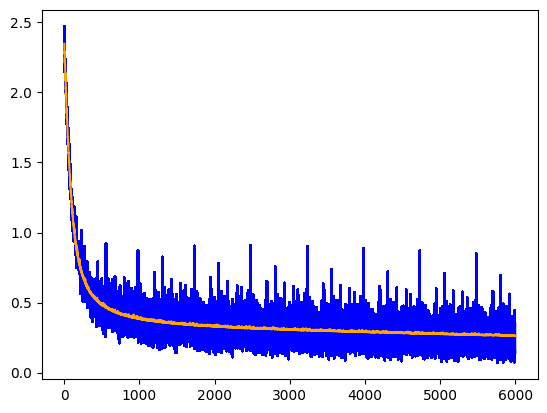

  1%|          | 5/750 [00:00<00:33, 22.34it/s]

Batch 0: Loss = 0.2779, Accuracy = 0.9219


 14%|█▍        | 104/750 [00:04<00:26, 24.84it/s]

Batch 100: Loss = 0.1190, Accuracy = 0.9844


 27%|██▋       | 203/750 [00:08<00:22, 24.74it/s]

Batch 200: Loss = 0.2055, Accuracy = 0.9375


 41%|████      | 305/750 [00:12<00:18, 24.70it/s]

Batch 300: Loss = 0.4258, Accuracy = 0.9219


 54%|█████▍    | 404/750 [00:16<00:14, 24.62it/s]

Batch 400: Loss = 0.1471, Accuracy = 0.9375


 67%|██████▋   | 503/750 [00:20<00:09, 24.90it/s]

Batch 500: Loss = 0.1344, Accuracy = 0.9375


 81%|████████  | 605/750 [00:24<00:05, 24.39it/s]

Batch 600: Loss = 0.2970, Accuracy = 0.9062


 94%|█████████▍| 704/750 [00:28<00:01, 24.70it/s]

Batch 700: Loss = 0.2519, Accuracy = 0.9688


100%|██████████| 750/750 [00:30<00:00, 24.60it/s]


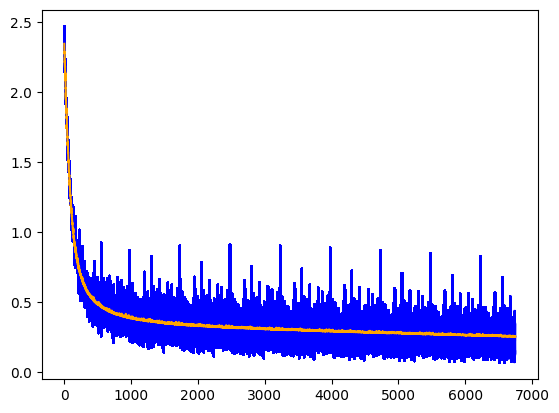

  1%|          | 5/750 [00:00<00:35, 20.71it/s]

Batch 0: Loss = 0.2677, Accuracy = 0.9219


 14%|█▍        | 104/750 [00:04<00:25, 24.91it/s]

Batch 100: Loss = 0.1088, Accuracy = 0.9844


 27%|██▋       | 203/750 [00:08<00:22, 24.29it/s]

Batch 200: Loss = 0.1925, Accuracy = 0.9375


 41%|████      | 305/750 [00:12<00:18, 24.59it/s]

Batch 300: Loss = 0.4055, Accuracy = 0.9219


 54%|█████▍    | 404/750 [00:16<00:14, 24.63it/s]

Batch 400: Loss = 0.1385, Accuracy = 0.9375


 67%|██████▋   | 503/750 [00:20<00:10, 24.64it/s]

Batch 500: Loss = 0.1261, Accuracy = 0.9375


 81%|████████  | 605/750 [00:24<00:05, 24.81it/s]

Batch 600: Loss = 0.2801, Accuracy = 0.9062


 94%|█████████▍| 704/750 [00:28<00:01, 24.98it/s]

Batch 700: Loss = 0.2366, Accuracy = 0.9688


100%|██████████| 750/750 [00:30<00:00, 24.54it/s]


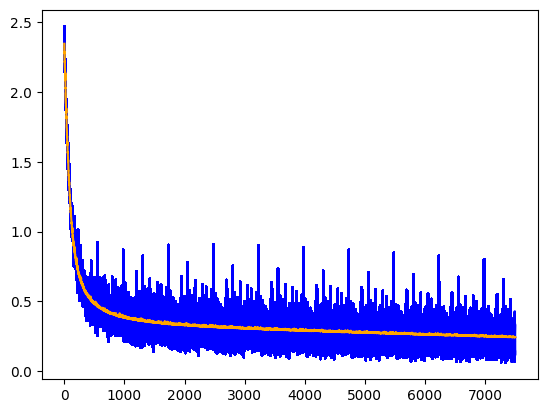

In [199]:
W1, b1, W2, b2 = train(X_train, Y_train, 0.1, 64, 10)

Our model stops training before validation loss begins its upward climb, indicating that we avoided major overfitting.

In [200]:
test_accuracy = make_predictions(W1, b1, W2, b2, X_test, Y_test)
print(test_accuracy)

0.935


Nice!

In [201]:
class Model:
    def __init__(self):
        self.W1 = W1
        self.b1 = b1
        self.W2 = W2
        self.b2 = b2

    def get_prediction(self, X):
        _, _, _, A2 = forward_prop(self.W1, self.b1, self.W2, self.b2, X)
        return np.argmax(A2, axis=-1)

In [202]:
model = Model()

In [203]:
with open('model.pkl', 'wb') as file:
    pickle.dump(model, file)